In [13]:
import numpy as np
from ase.io import read
from ase.visualize import view
import matplotlib.pyplot as plt
from ase.geometry.analysis import Analysis
import copy

from tqdm import tqdm

import math

In [14]:
def RDF(frame, cutoff):

    vec_cell = frame.cell.cellpar()
    
    M1, M2, M3 = vec_cell[0]**2, vec_cell[1]**2, vec_cell[2]**2
    M12 = vec_cell[0]*vec_cell[1]*np.cos(vec_cell[5]*np.pi/180)
    M13 = vec_cell[0]*vec_cell[2]*np.cos(vec_cell[4]*np.pi/180)
    M23 = vec_cell[1]*vec_cell[2]*np.cos(vec_cell[3]*np.pi/180)
    det_M = M1*M2*M3-M1*M23**2-M2*M13**2-M3*M12**2+2*M12*M13*M23
    
    N1=math.ceil(np.sqrt((M2*M3-M23**2)/det_M)*cutoff)
    N2=math.ceil(np.sqrt((M1*M3-M13**2)/det_M)*cutoff)
    N3=math.ceil(np.sqrt((M1*M2-M12**2)/det_M)*cutoff)
    
    pbc = frame.get_pbc()
    cell_size = [(2*N1+1) if pbc[0] else 1,
                  (2*N2+1) if pbc[1] else 1, 
                  (2*N3+1) if pbc[2] else 1]
    n_cellsahead = math.floor(np.prod(cell_size)/2)
    incre = n_cellsahead * len(frame)
    frame2=frame*(cell_size[0],cell_size[1],cell_size[2])
    
    dist_mat = frame2.get_all_distances()
    
    plot_dict = {}
    
    for i in dist_mat[incre:incre+len(frame)].flatten():
        if i != 0:
            if i in plot_dict.keys():
                plot_dict[i] += 1
            else:
                plot_dict[i] = 1
        else:
            pass
    
    r = []
    n = []
    
    for key, value in plot_dict.items():
        r.append(key)
        n.append(value)
    
    r = np.array(r)
    n = np.array(n)
    
    return r, n

In [15]:
def plot_ave_rdf(frames,r=6.,bins=150,key=None,save=False):
    
    '''
    
    This function is used to calculate the average rdf per atom!
    
    frames: all the frames where we want to calculate the average rdf
    r: the cutoff distance
    bins: number of points
    
    '''
    
    frames2=copy.deepcopy(frames)
    n=len(frames)
    ave_rdf=np.zeros(bins)
    
    for frame in frames2:
        try:
            ana=Analysis(frame)
            rdf=ana.get_rdf(r,bins, return_dists=True)
        except:
            cell_size = extend_cell(frame, r)
            frame*=(cell_size[0],cell_size[1],cell_size[2])
            ana=Analysis(frame)
            rdf=ana.get_rdf(r,bins, return_dists=True)
        ave_rdf+=rdf[0][0]
    
    ave_rdf=ave_rdf/n
    
    x=(np.linspace(0,r,bins+1)[1:]+np.linspace(0,r,bins+1)[:-1])/2
    
    plt.figure()
    plt.plot(x,ave_rdf)
    plt.xlabel('Radius (Angstrom)',fontsize='x-large')
    if key is not None:
        plt.title('Frame number: '+str(key),fontsize='x-large')
    plt.xticks(fontsize='x-large')
    plt.yticks([])
    plt.tight_layout()
    
    if save:
        plt.savefig('./RDF/{}.png'.format(key),format='png')
    
    plt.show()
    plt.close()

def extend_cell(frame,r_cut):
    
    vec_cell = frame.cell.cellpar()
    M1, M2, M3 = vec_cell[0]**2, vec_cell[1]**2, vec_cell[2]**2
    M12 = vec_cell[0]*vec_cell[1]*np.cos(vec_cell[5]*np.pi/180)
    M13 = vec_cell[0]*vec_cell[2]*np.cos(vec_cell[4]*np.pi/180)
    M23 = vec_cell[1]*vec_cell[2]*np.cos(vec_cell[3]*np.pi/180)
    det_M = M1*M2*M3-M1*M23**2-M2*M13**2-M3*M12**2+2*M12*M13*M23
    N1=math.ceil(np.sqrt((M2*M3-M23**2)/det_M)*r_cut)
    N2=math.ceil(np.sqrt((M1*M3-M13**2)/det_M)*r_cut)
    N3=math.ceil(np.sqrt((M1*M2-M12**2)/det_M)*r_cut)
    
    pbc = frame.get_pbc()
    
    cell_size = [(2*N1+1) if pbc[0] else 1,
                  (2*N2+1) if pbc[1] else 1, 
                  (2*N3+1) if pbc[2] else 1]
    return cell_size

In [16]:
frames = read("exfoliation_mbd_reference.xyz", ":")

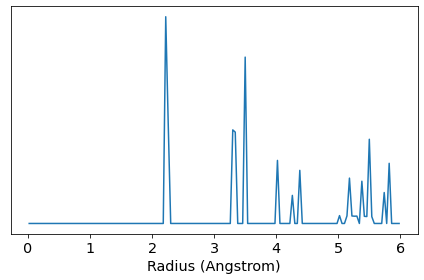

In [17]:
plot_ave_rdf(frames[30:35])

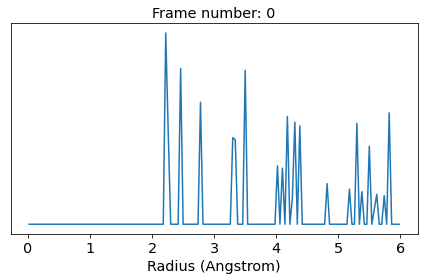

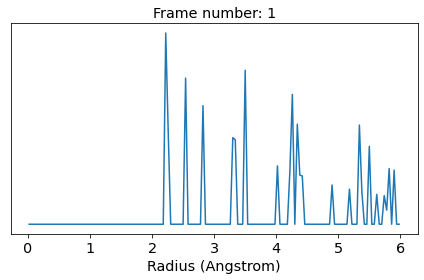

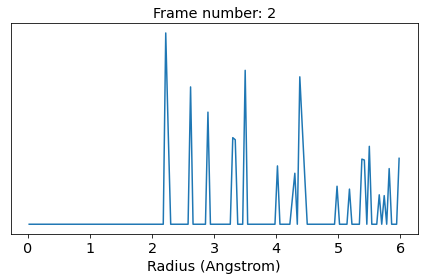

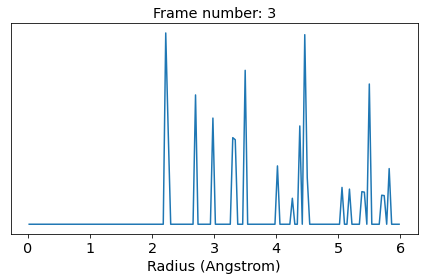

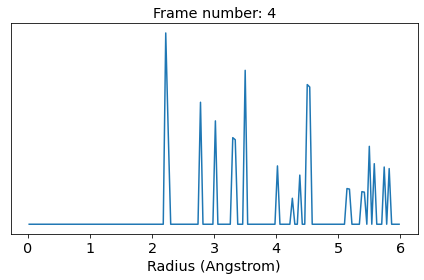

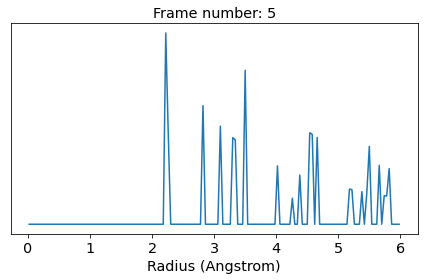

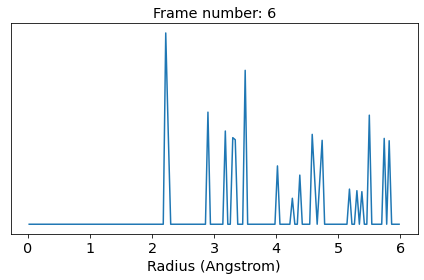

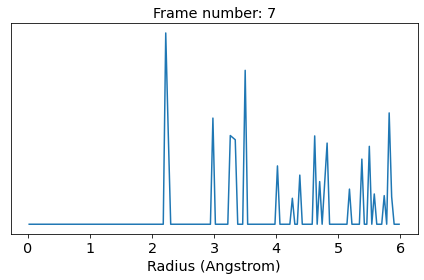

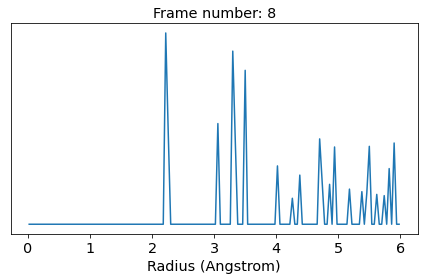

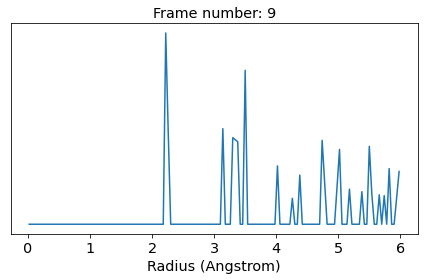

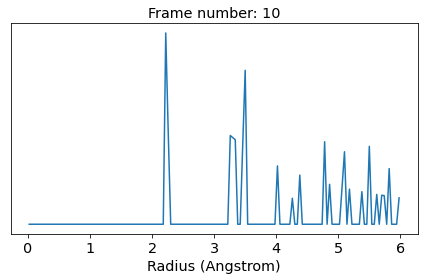

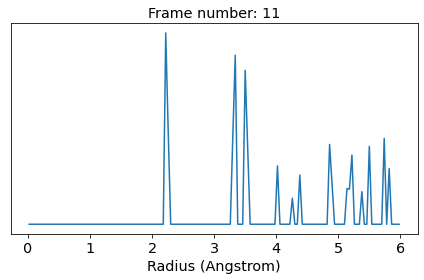

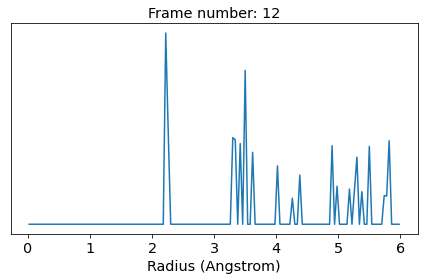

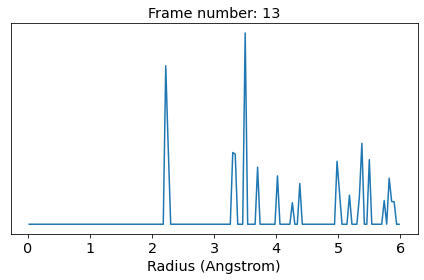

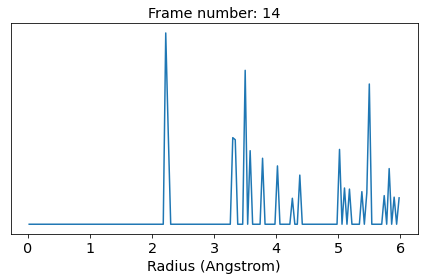

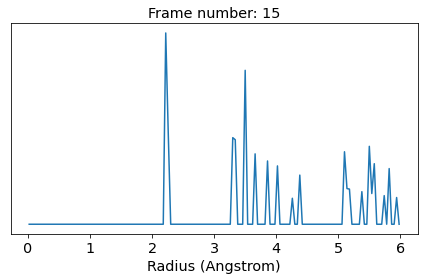

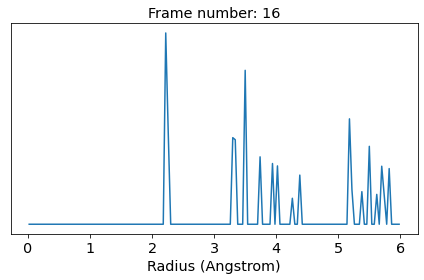

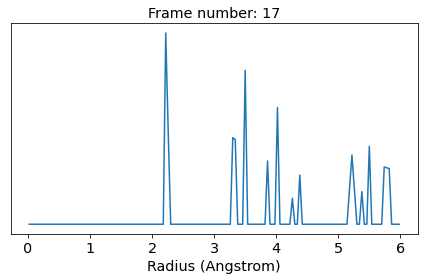

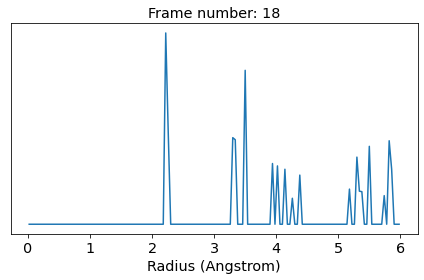

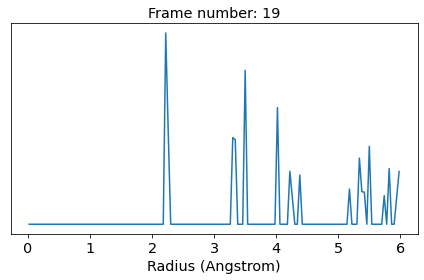

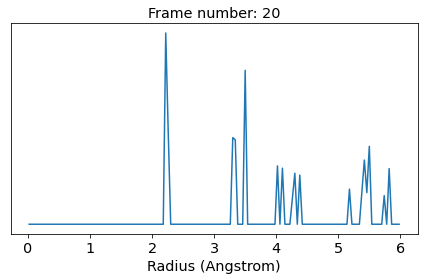

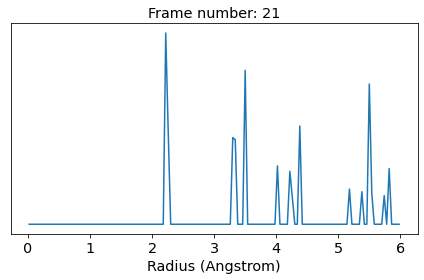

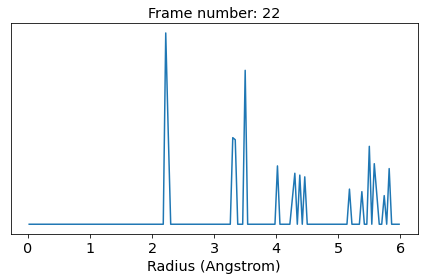

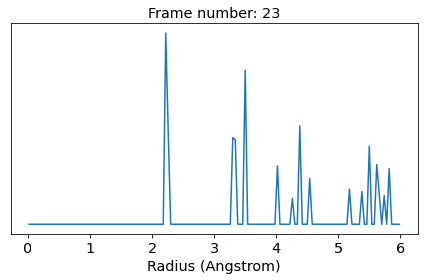

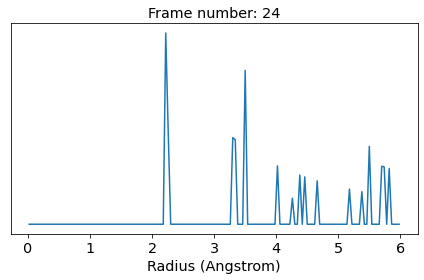

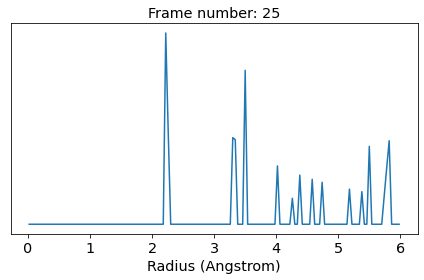

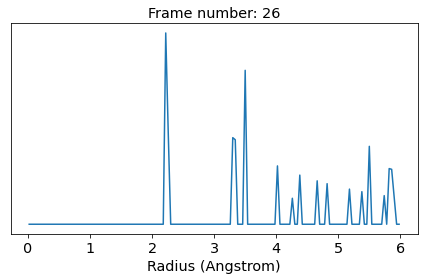

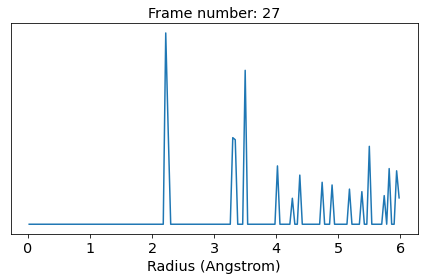

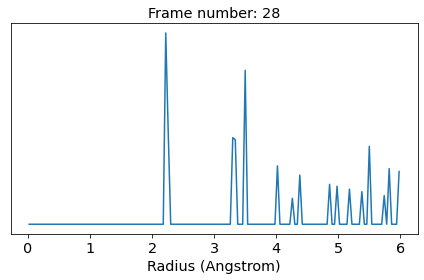

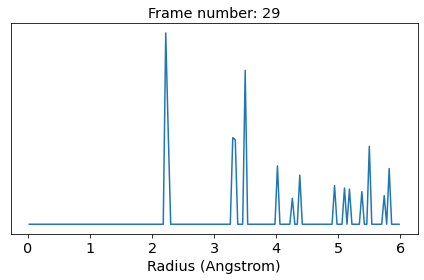

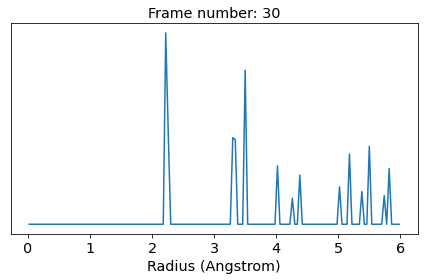

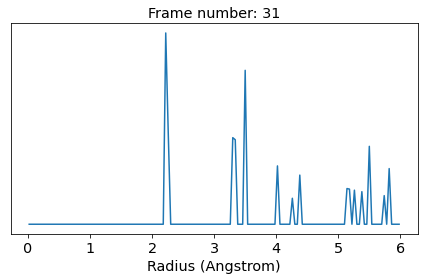

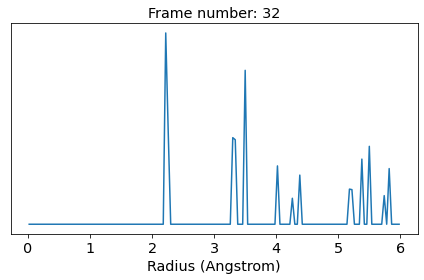

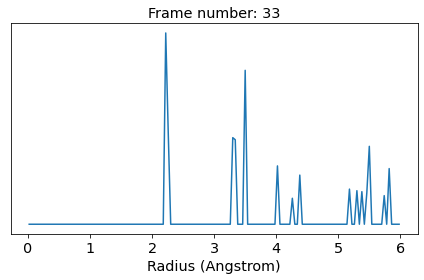

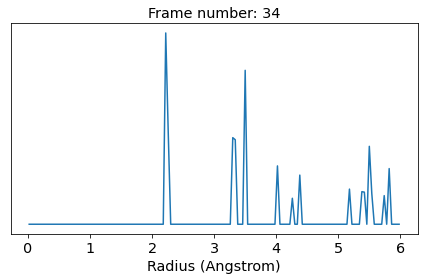

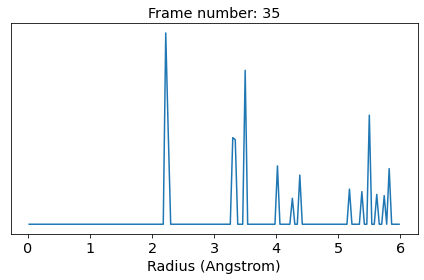

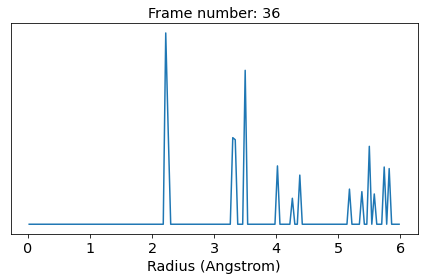

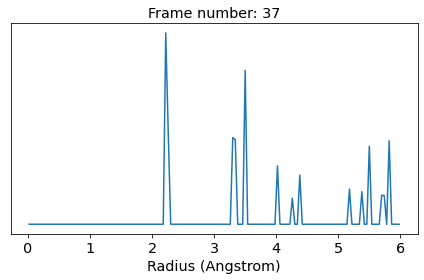

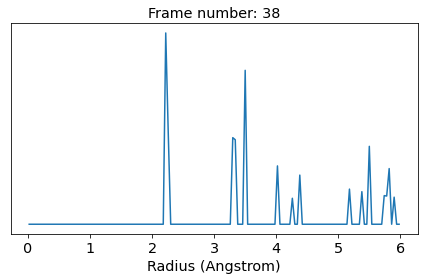

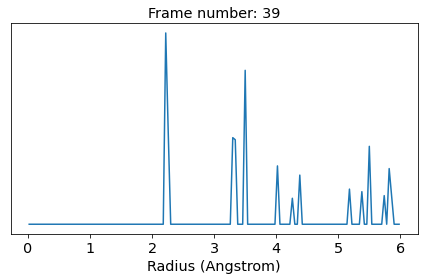

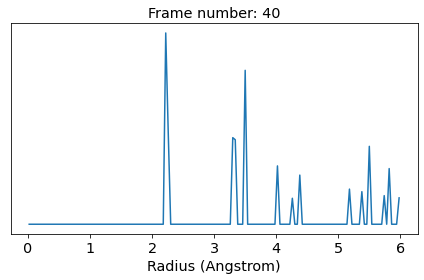

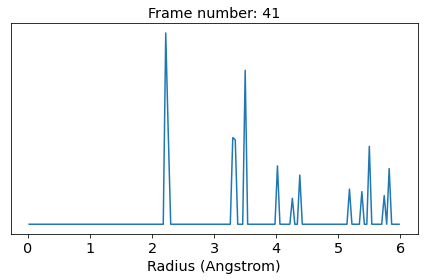

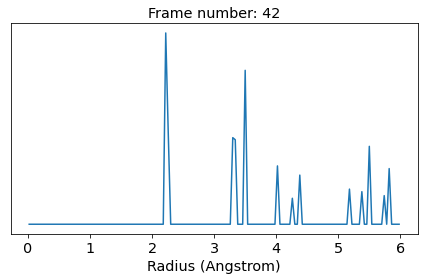

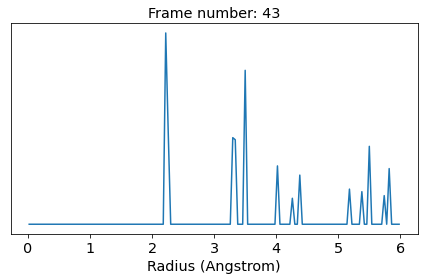

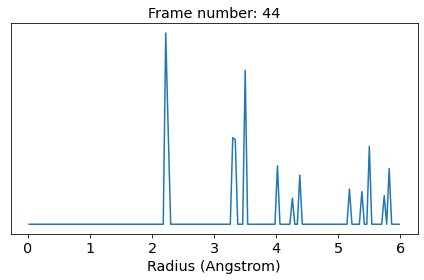

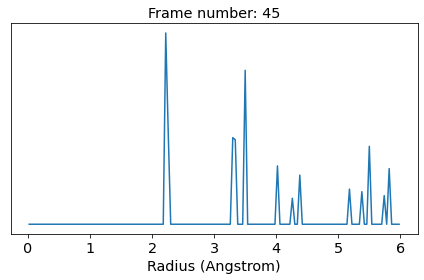

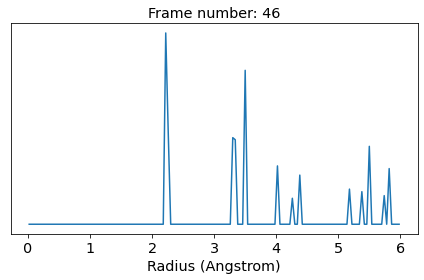

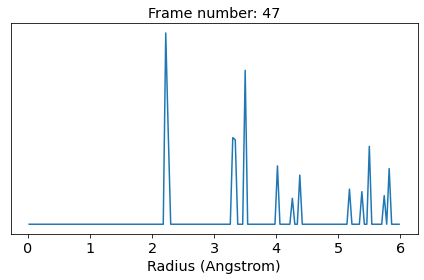

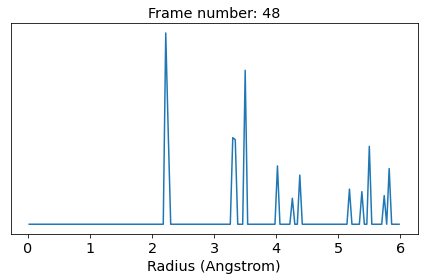

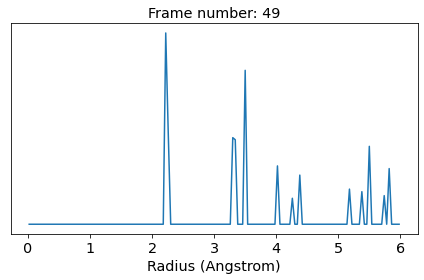

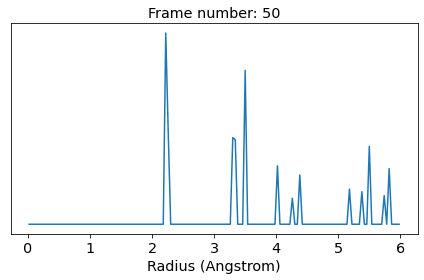

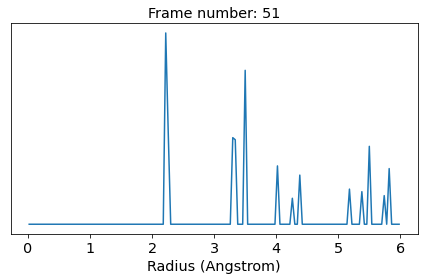

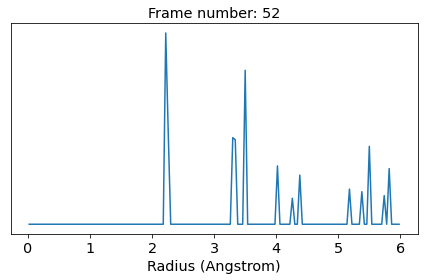

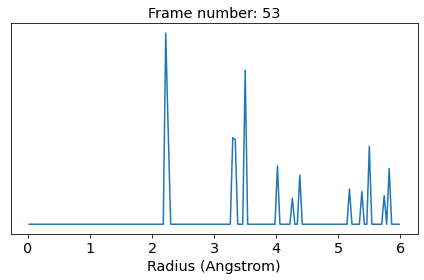

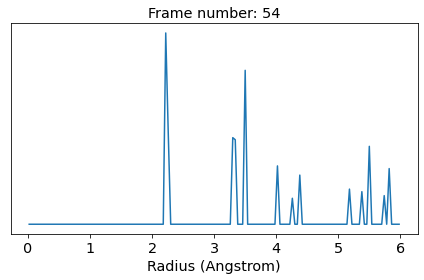

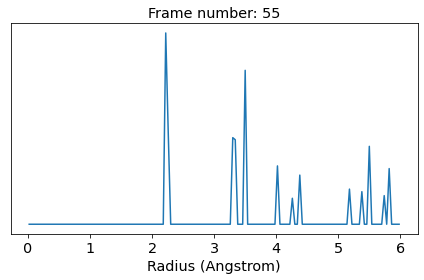

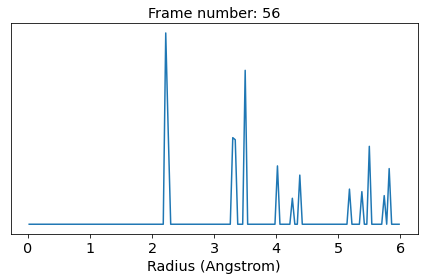

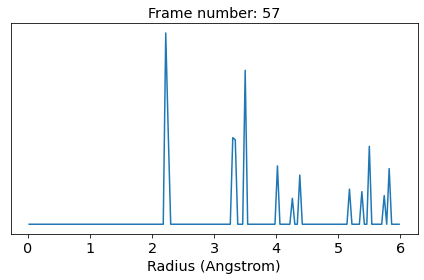

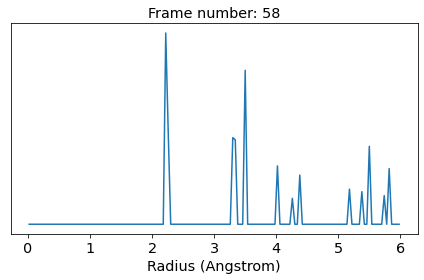

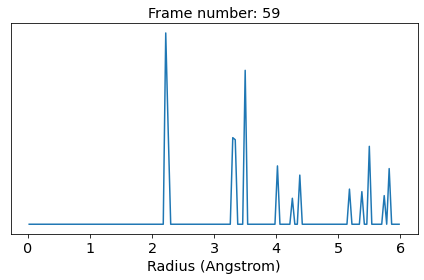

In [18]:
for i in np.arange(60):
    plot_ave_rdf(frames[i:i+1],key=i,save=True)

In [19]:
### keep in mind that the integral of RDF is the number of atoms up to the upper limit of the integration